# Lab 6 - Denoising

In this lab we will use denoising to clean up some noisy recordings. We will use the following sounds:

Speech in a room: [https://drive.google.com/uc?export=download&id=1g5nbBpNbCjqs8cSoW0Lb-owe15tswDwW ]

ATC: [https://drive.google.com/uc?export=download&id=1fh5iL5qRj3-PUP_sG5-QE5DofACY_Hr5 ]

Speech with wind: [https://drive.google.com/uc?export=download&id=1g7TIkLpnWDFNUQYgCqIUoSOkk5EIK16_ ]



In [1]:
import numpy as np
from scipy.io.wavfile import read
from scipy import signal
import matplotlib.pyplot as plt
import os
import copy
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

## Part 1. Cleaning up the sounds

Let’s start by cleaning up these sounds as best as we can. We will do a straightforward magnitude spectral subtraction. For all of these sounds there is only noise in the first few seconds of the recording so that you can learn a noise profile from there. Do the following:
Perform an STFT of the recordings

- Estimate the magnitude spectrum of the noise from the beginning of the recording
    - It’s up to you to figure out how many seconds to use (hint: look at the spectrogram)

- Perform spectral subtraction by subtracting that spectrum from the input’s magnitude STFT
    - Remember to clip any resulting negative values to zero
    - Try to find how much of the noise to subtract so that the output looks good

- Use the original signal’s phase to convert back to a time series.

Make a note of which examples sound the best and are easier to work with. Try to explain why.
At this point some of the outputs will exhibit “musical noise”. To minimize its effects apply a median filter on the denoised magnitude spectrogram to make it sound better (hint: ```scipy.signal.medfilt2```). How big should the median window be? Try different values and find which work best.


### Clean up using spectral subtraction only

In [2]:
# YOUR CODE HERE
# raise NotImplementedError()
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))
        
def get_stft(x, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    assert dft_size >= hop_size, "DFT size should be larger than hop size."
    if window=='hanning':
        w = np.hanning
    elif window=='hamming':
        w = np.hamming
    elif window=='kaiser':
        w = np.kaiser
    else:
        raise "Unsupported window type. Window should be either 'hanning', 'hamming' or 'kaiser'."
    L = len(x)
    num_frame = (L-dft_size)//hop_size
    tail = L-(num_frame*hop_size+dft_size)
    if tail>0:
        pad = hop_size-tail
        x = np.pad(x, (0,pad), 'constant')
        num_frame += 1
    stft = np.zeros((num_frame, int((dft_size+zero_pad)/2)+1)).astype(complex)
    for i, t in enumerate(stft[:]):
        input_f = x[i*hop_size:i*hop_size+dft_size].astype(float)
        input_f *= w(len(input_f))
        input_f = np.pad(input_f, (0, zero_pad), 'constant')    
        stft[i] = np.fft.rfft(input_f)
    stft = stft.T
    # Return padded input sound and a complex-valued spectrogram (frequencies x time)
    return stft

def get_istft(stft, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    assert dft_size >= hop_size, "DFT size should be larger than hop size."
    if window=='hanning':
        w = np.hanning
    elif window=='hamming':
        w = np.hamming
    elif window=='kaiser':
        w = np.kaiser
    else:
        raise "Unsupported window type. Window should be either 'hanning', 'hamming' or 'kaiser'."
    
    T = stft.shape[1]
    L = hop_size*T+dft_size+zero_pad
    x = np.zeros(L)
    for t in range(T):
        curr_frame = stft[:, t]
        ifft = np.fft.irfft(curr_frame)
        ifft *= w(len(ifft)) * 0.7
        idx = t*hop_size
        x[idx:idx+dft_size+zero_pad] += ifft
    return x

def plot_spectrogram(x, stft, fs, title):
    x = x/ np.max(x)
    t = np.linspace(0, len(x)/fs, stft.shape[1])
    f = np.linspace(0, int(fs/2), stft.shape[0])
    plt.pcolormesh(t, f, abs(stft)**.3)
    plt.title(title.capitalize()+' Spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    
def spect_subtraction(stft, noise_stft, alpha):
    phase = np.angle(stft)
    diff = np.abs(stft) - alpha * np.abs(noise_stft)
    diff[diff<0] = 0
    stft_out = diff * np.exp(1j*phase)
    return stft_out
    
def clean_sound(fname, Tn, alpha, use_med=0, dft_size=512, hop_size=128, zero_pad=0, window='hanning'):
    title = os.path.splitext(fname)[0]
    fs, x = read(fname)   
    stft = get_stft(x, dft_size, hop_size, zero_pad, window)
    plot_spectrogram(x, stft, fs, title)
    
    noise = x[:int(Tn*fs)]
    noise_stft = get_stft(noise, dft_size, hop_size, zero_pad, window)
    n_repeat = stft.shape[1]//noise_stft.shape[1]
    n_residual = stft.shape[1]%noise_stft.shape[1]
    noise_stft_rp = np.tile(noise_stft, (1, n_repeat))
    noise_stft_rp = np.hstack((noise_stft_rp, noise_stft[:,:n_residual]))
    
    stft_out = spect_subtraction(stft, noise_stft_rp, alpha)
    if use_med:
        phase = np.angle(stft_out)
        mag = np.abs(stft_out)
        mag = signal.medfilt2d(mag, use_med)
        stft_out = mag * np.exp(1j*phase)
    x_out = get_istft(stft_out, dft_size, hop_size, zero_pad, window)
    plot_spectrogram(x_out, stft_out, fs, title+'_out')
    
    sound(x, rate=fs, label=title)
    sound(x_out, rate=fs, label=title+'_out')

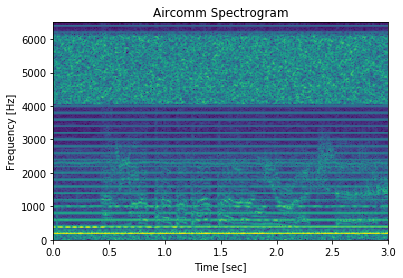

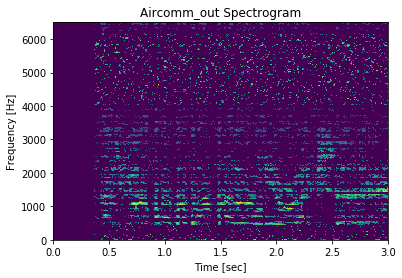

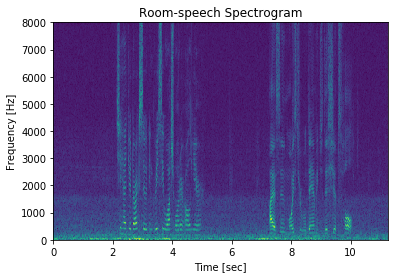

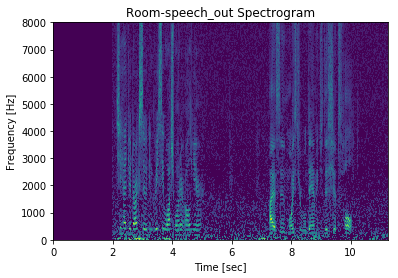

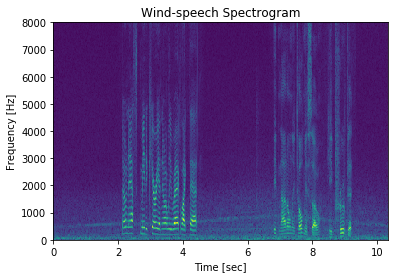

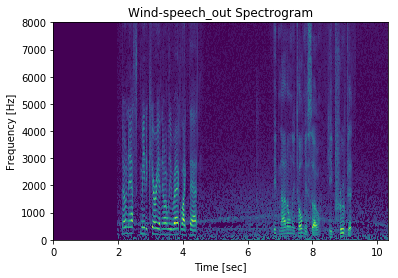

In [3]:
clean_sound(fname='aircomm.wav', Tn=0.4, alpha=3.5)
clean_sound(fname='room-speech.wav', Tn=2, alpha=1.0)
clean_sound(fname='wind-speech.wav', Tn=2, alpha=1.0)

As the above plots show, it is easiet to denoise the room speech among the three. This is because the room noise has high energy at low frequencies with consistent spectral representations maintained across all the frames. Therefore, the noise spectrum of the first few frames can model noise spectrum of all other frames very well, making the spectral subtraction a very effective filter. The aircomm, on the other hand, not only displays noise with different characteristics at different frequency bins, but also contains white noise at high frequencies which is very hard to model by the spectrum of leading frames. Finally, although the wind noise has high energy at low frequencies just like the room noise, the fundamental frequency actually increases over time. Therefore, the noise is not stationary either, so spectral subtraction also fails.

### Clean up using spectral subtraction and median filter

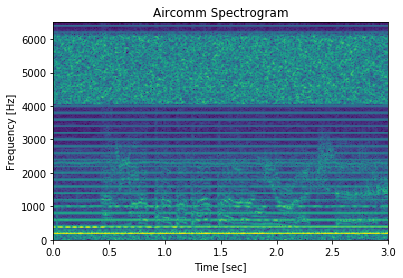

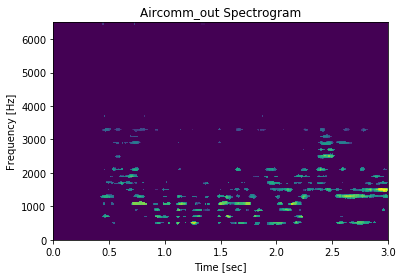

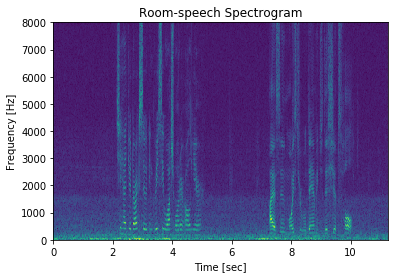

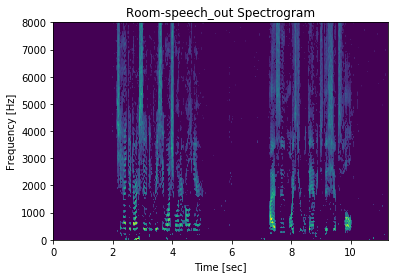

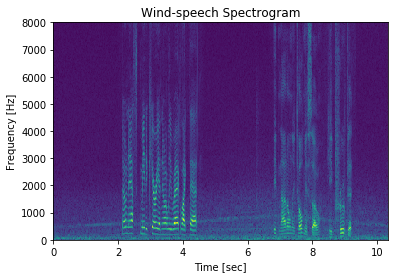

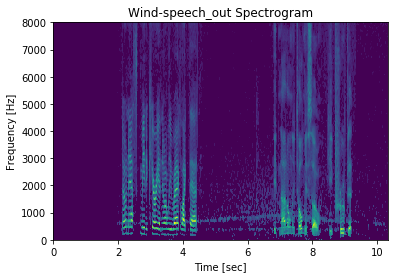

In [4]:
clean_sound(fname='aircomm.wav', Tn=0.4, alpha=3.5, use_med=5)
clean_sound(fname='room-speech.wav', Tn=2, alpha=3.0, use_med=3)
clean_sound(fname='wind-speech.wav', Tn=2, alpha=3.0, use_med=3)

By using median filters, we can improve results for both the aircomm and the room speech. It turns out a median filter of kernel size 5 is good for the aircomm while 3 is good for the room speech. For the wind speech, the wind is still present in trailing frames, which calls for further processing as shown below.

## Part 2. Implement a Voice Activity Detector (VAD)


For the last sound we have an evolving noise profile, which causes problems since our noise description from the first two seconds isn’t accurate throughout. Because we’re lazy we want to automatically update the noise model and not to select it manually. To do so we need a VAD that lets us know when to gather noise statistics and when to denoise. Do the following:

- Take the square of the input waveform and lowpass filter it (a lot) to get an energy level over time
    - Experiment with the cutoff frequency so that you get a smooth energy-looking function
- Set a threshold over which we seem to have speech in the input
- Implement a real-time spectral subtraction denoiser
    - If an input frame is under threshold, it is noise
    - Keep track of the last few noise frames and their average amplitude will be your noise spectrum
    - If an input is over the threshold it is speech
    - Once you encounter speech perform spectral subtraction with the current noise estimate

In [5]:
# YOUR CODE HERE
# raise NotImplementedError()

def get_lpf(numtaps, f, fs):
    return signal.firwin(numtaps, f, pass_zero='lowpass', fs=fs)

def apply_lpf(lpf, x_sq):
    lpf_x = signal.convolve(x_sq, lpf)
    return lpf_x

def get_vuv(lpf_stft, L):
    vuv = []
    for i in range(lpf_stft.shape[1]):
        s = np.sum(np.abs(lpf_stft[:,i]))
        vuv.append(0) if s<L else vuv.append(1)
    return vuv
        
def vad_spect_subtraction(stft, vuv, init_f, alpha):
    stft_out = copy.deepcopy(stft)
    noise_queue = stft[:, :init_f]
    for i in range(stft_out.shape[1]):
        if vuv[i] == 0:
            noise_queue = np.roll(noise_queue, 1, axis=1)
            noise_queue[:, -1] = stft[:, i]
            stft_out[:, i] = 0
        else:
            noise_avg = np.mean(noise_queue, axis=1)
            phase = np.angle(stft_out[:, i])
            diff = np.abs(stft_out[:, i]) - alpha * np.abs(noise_avg)
            diff[diff<0] = 0
            stft_out[:, i] = diff * np.exp(1j*phase)
    return stft_out

def vad_clean_sound(fname, numtaps, f, L, init_f, alpha, dft_size=512, hop_size=128, zero_pad=0, window='hanning'):
    title = os.path.splitext(fname)[0]
    fs, x = read(fname)
    stft = get_stft(x, dft_size, hop_size, zero_pad, window)
    plot_spectrogram(x, stft, fs, title)
    lpf = get_lpf(numtaps, f, fs)
    x_sq = x**2
    lpf_x = apply_lpf(lpf, x_sq)
    lpf_stft = get_stft(lpf_x, dft_size, hop_size, zero_pad, window)
    vuv = get_vuv(lpf_stft, L)
    stft_out = vad_spect_subtraction(stft, vuv, init_f, alpha)
    x_out = get_istft(stft_out, dft_size, hop_size, zero_pad, window)
    plot_spectrogram(x_out, stft_out, fs, title)
    sound(x, fs, title)
    sound(x_out, fs, title+'out')

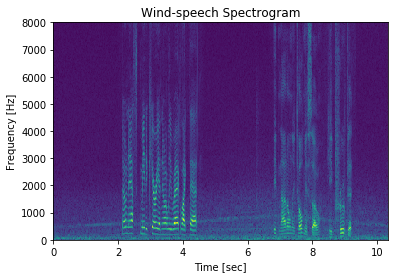

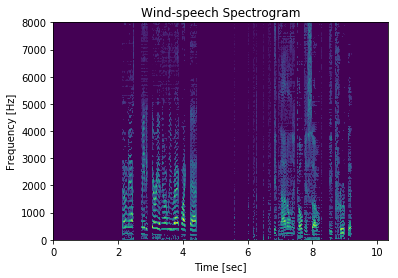

In [6]:
vad_clean_sound(fname='wind-speech.wav', numtaps=251, f=np.array([2000, ]), L=2.5, init_f=3, alpha=2.0)